# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames


# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [8]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [172,196,401]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

print "Percentage difference from the median values"
diff_vect = samples - data.median()
perc=diff_vect/data.median()*100
pd.options.display.float_format = '{:,.0f}'.format
display(perc)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,955,5479,6536,333,2840,707
1,30624,7209,4897,18711,763,2876
2,27167,2801,2128,13223,92,1902


Percentage difference from the median values


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-89,51,37,-78,248,-27
1,260,99,3,"1,126",-7,198
2,219,-23,-55,767,-89,97


## Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**

* Bed & Breakfast, Restaurants, Hotels, Cafe's, Catering Servies,Retailers etc*

*0 - Can represent a café looking at features like milk, groceries and detergent paper which are within the range of the second and third Quartile. A cafe usually serves light snacks, a lot of coffee and drinks, so there is little need for fresh or frozen food.*

*1 - Can represent a a hotel, a lot of the features range from the first to the second quartile. A hotel will be stocked with a varitey of fresh and frozen food, groceries and cleaning products.*

*2 - Can represent a restaurant, a lot of the features range from the first to the second quartile. A restaurant will be stocked with a varitey of fresh and frozen food, groceries and  less cleaning products as people only go there to eat.*

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [4]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

feature = "Delicatessen"
new_data = data.drop(feature, axis = 1)

# TODO: Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, data[feature], test_size = 0.25, random_state = 1)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state =1)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
y_pred = regressor.predict(X_test)
score = r2_score(y_test, y_pred)  
print "Prediction: " + str(score)

Prediction: -0.429125195659


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature relevant for identifying a specific customer?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

*I attempted to predict Delicatessen, the reported score was -0.42912. Given that the model failed to fit the data, it is  releveant for identifying a specific customer since it has no correlatin wth other features.
*

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

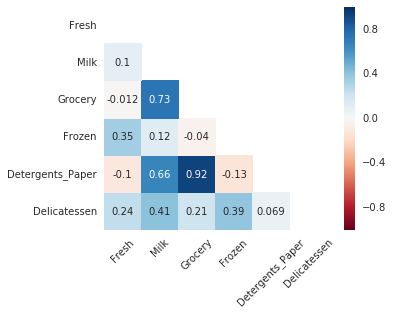

In [36]:
# Produce a scatter matrix for each pair of features in the data
#pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu')
    plt.xticks(rotation=45, ha='center');


### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**

**a.)** *There are a pair of feature that exhibit some degree of correlation (milk,grocery),(milk,detergent_paper),(grocery,detergent-paper).*

**b.)** *It confirms my suspicion about the relevance of feature that i tried to predict as there is very little to no correlation when Delicatessen is paired with fresh,milk,grocery,frozen and detergent-paper.*

**c.)** *The data is skewed to the right and is not normally distributed, as the bulk of the data is concentrated at one part of the graph and the sparsely spread out. most of the data point lie between 0 - 20,000.*

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

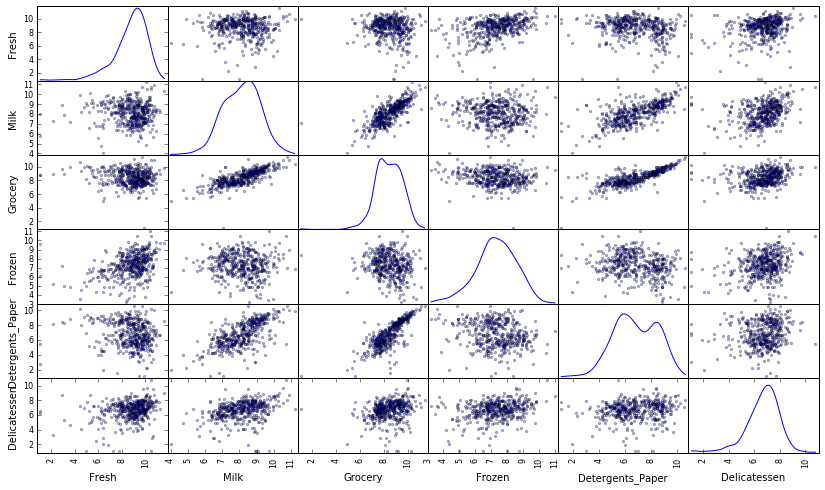

In [5]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [6]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6.861711,8.608678,8.785081,5.808142,7.951559,6.561031
1,10.329539,8.883086,8.496378,9.836867,6.637258,7.964156
2,10.209758,7.937732,7.662938,9.489713,4.521789,7.550661


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [7]:
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    IQR = Q3 - Q1
    step = 1.5 * IQR
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = [65,66,75,154,128]
#outliers  = []

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**

**a.)** *Datapoints (65,66,75,154,128) appear more than once.*

**b.)** These data points should be removed because they appeare more than once in the listsets and their removal doesn't affect the overall trend of the data.

**c.)** The data points were added to the list becuase the k-means clustering algorithm is outlier sensitive since it tries to optimize the sum of square causing outliers to get a lot of weight. 


## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. 

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition import PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

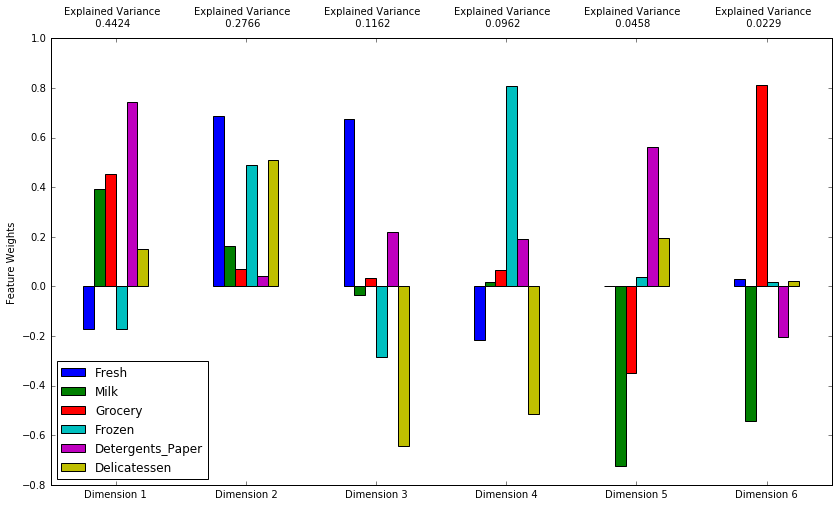

In [28]:
# TODO: Apply PCA to the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(good_data)

# explained variance in the PC's 
#print "variance:", pca.explained_variance_ratio_

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**

**a.)** *The total variance explained by the first and second pc's = 0.7190.*

**b.)** *The total variance explained by the first to the fourth pc's = 0.93414.*

**c.)** 
**The First Principal Component Analysis:**
*This tells us that there is a strong correlation with 3 of the 6 variables,The first dimesion increases with increasing Detergents_Paper, Grocery and milk scores.We see a very strong correlation between the first pc and Detergents_paper and that it is primarily a measure of Detergents_paper. Companies that need a lot of cleaning utensils for the bathrooms and kitchen and snacks for the vending machines.*

**The Second Principal Component Analysis:**
*Again we see a strong correlation with 3 of the 6 variables,The second dimesion increases with increasing Fresh, Frozen and Delicatessen scores.We see a very strong correlation between the second pc and Fresh and that it is primarily a measure of Fresh. it would follow that Restaurants with a high need for fresh food will also need a high amount of frozen foods and Delicatessen.* 

** The Third Principal Component Analysis:**
*We see a strong correlation with only 2 of the 6 variables,The third dimesion increases with increasing Fresh and Delicatessen scores.We see a very strong correlation between Fresh and Delicatessen. This suggests that Catering Services with a high need for fresh food will not need Delicatessen *

** The Fourth Principal Component Analysis:**
*We see a strong correlation with only 2 of the 6 variables,The third dimesion increases with increasing Frozen and Delicatessen scores.We see a very strong correlation between Frozen and Delicatessen. This suggests that convenient food store with a high need for frozen food will not need Delicatessen *

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [14]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,1.7838,-1.9098,-0.5170,-0.4969,0.1091,-0.3040
1,-0.3054,3.1155,-0.5384,1.0235,-0.3065,-0.2181
2,-2.6153,2.3534,-0.7109,0.5083,-0.6195,0.0262


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [15]:
# TODO: Fit PCA to the good data using only two dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [12]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,1.7838,-1.9098
1,-0.3054,3.1155
2,-2.6153,2.3534


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**
#### K-Means Clustering Advanatges
- *With a large number of variables, K-Means may be computationally faster than hierarchical clustering (if K is small).*

- *K-Means may produce tighter clusters than hierarchical clustering, especially if the clusters are globular.*

- *Fast and convergent in a finite number of steps.*

#### Gaussian Mixture Model Advantages
- *Well-studied statistical inference techniques available.*

- *Flexibility in choosing the component distribution*.

- *Obtain a density estimation for each cluster.*

- *A “soft” classification is available.*

**c.)** *Given our observation of the data, we see that there are some similarities between customers. if we use k-means, certain customers may be clusterd into morning delivery where as they may actually want evening deliveries (hard-clustering). If we use GMM it gives us the probability density of a customer being a morning delivery or evening delivery (soft-clustering) *

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [16]:
# TODO: Apply your clustering algorithm of choice to the reduced data 
import numpy as np
from sklearn import mixture 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(6,1,-1):
    #clusterer = mixture.GMM(n_components= 2)
    clusterer =  KMeans(n_clusters = k, random_state=1)
    clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    #centers = np.round(clusterer.means_, 2)
    centers = np.round(clusterer.cluster_centers_, 2)

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds)
    silhouette_scores.append(score)
    print k, 'clusters:', score.round(5)



6 clusters: 0.36017
5 clusters: 0.34783
4 clusters: 0.32983
3 clusters: 0.3943
2 clusters: 0.41917


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

**2 clusters** - 0.41971

**3 clusters** - 0.39347

**4 clusters** - 0.33288

*Two clusters has the best silhouette.*


### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

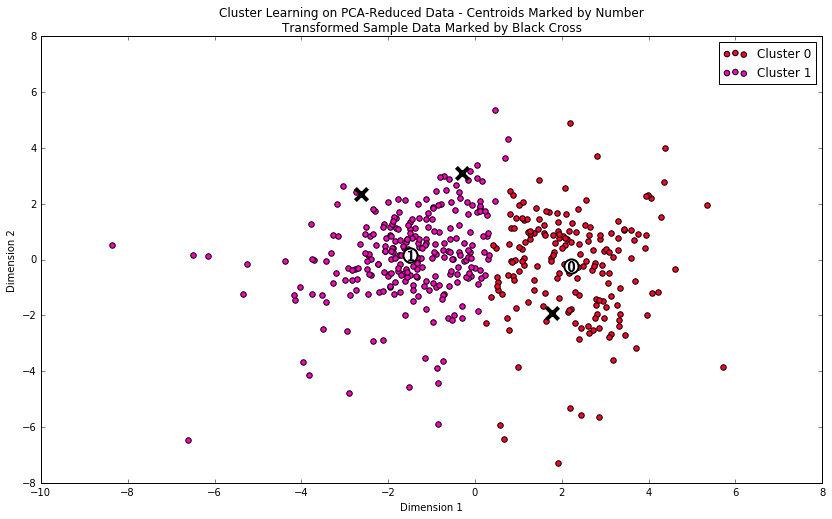

In [17]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [22]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3577,7738,12440,901,4553,966
Segment 1,8962,1911,2370,2075,291,680


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

**cluster 0 **- Should represent a cafe.

Features like Milk,Groceries,Detergents_Paper and Delicatesssen are higher than the mean and are higher than or equal to the median.
Where as features like fresh and frozen aren't, this could due to fact that people come to cafe's mostly for coffee and snacks. 

**
cluster 1**- Should represent a catering services or a resaurant.

Features like fresh and frozen are closer to the mean and are higher than or equal to the median.
Where as features like milk, groceries and delicatessen though they  are less than the mean, they are closer to the median.








### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [23]:
# Display the predictions sample
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


**Answer:**

*Sample point 0 predicted to be in Cluster 0.  *

*Sample point 1 predicted to be in Cluster 1.*

*Sample point 2 predicted to be in Cluster 1.*

The sample points for each prediction are consistent.

When comparing the features of sample point 0 to the segements, we see that Milk, Groceries and Detergents_Paper are the only features that are very close to or above the mean. This is very similar to segement 0 since they are closer in values. but for segement 0, those features have values that are above the mean.

When comparing the features of sample point 1 and 2 to the segements, we see that features like Fresh,Frozen and Delicatessen are well above the mean, while features like Milk and Groceries are the only features that
are very close to the mean, but still under the mean. This is very similar to segement 1, but the sample points in this case have higher feautur values. 


## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:**

*We can look at the fresh food column and tally the total purchase amount in each segement. Which ever segment has the highest amount of money spent in that category, we proceed with testing that group.

Given that we have two cluster, we can select customers from each cluster that are near idententical or in best case identical to the other. Then we can procced with testing. The experimental group will be given the new 3-day schedule and the control group will continue with its 5-day schedule. Given the result that company gets from testing the experimental group, the company can taylor its delivery services that soothes its customer. customers that depend on regular restocking of products are more likely to be impacted more by the changes in the delivery service. *

### Question 11
*Assume the wholesale distributor wanted to predict some other feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the data to assist a supervised learning analysis?*

**Answer:**

*Through unsupervised learning, we have clustered our dataset and created labels. We have essentially created a new feature for the dataset including the six orginal features. So with the cluster label feature, we are able to segment certain customers from one another. We can use the new feature as an additional input feature to a supervised learner and try to predict a binary classification variable that relates to the new delivery scheme (0 - negatively affects customer; 1 - positively affects customer).*

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

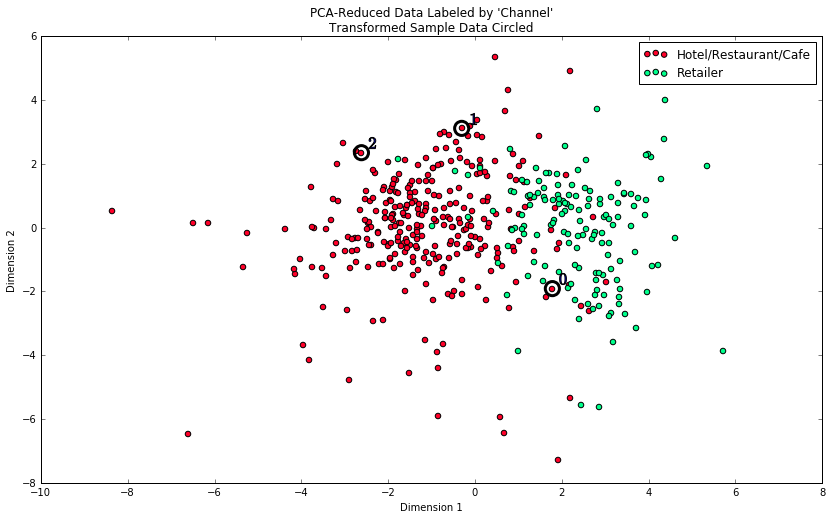

In [24]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

*The clustering algorithm and number of clusters i've chosen compare very well to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers. However, there are no segments that will be classifed as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution. I would consider these classification consistent for the most part. *

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.